### 1. Finray Simulation

In [54]:
import mujoco
import mujoco_viewer
import numpy as np
import os
from lxml import etree
import lxml.etree as ET
import time
import uuid
import tempfile


##############################################
# Helper functions for XML attribute swapping
##############################################
def swap_par(tree, element_type, element_name, attribute_name, new_value):
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    if element is not None:
        element.set(attribute_name, new_value)

##############################################
# Helper function to add a dynamic site to a body
##############################################
def add_dynamic_site(tree, body_name, site_name, pos):
    body_elem = tree.find(f'.//body[@name="{body_name}"]')
    if body_elem is not None:
        new_site = ET.Element("site", name=site_name, size="0.0001", pos=pos, rgba="1 0 0 1")
        body_elem.append(new_site)
    return site_name

#########################################################
# Function to generate a cantilever beam XML segment string
#########################################################
def generate_xml(ID, n):
    xml_output = []
    n_closers = n
    if isinstance(ID, str) and ID.startswith("R"):
        xml_output.append('<body>')
        xml_output.append('<joint type="free"/>')
        n_closers += 1
    xml_output.append(f'<body name="ID{ID}_b_0" pos="0 0 0" euler="0 0 0">')
    xml_output.append(f'<site name="ID{ID}_b_0_sroot" size="0.0001" pos="0 0 0"/>')
    xml_output.append(f'<geom name="ID{ID}_b_0_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
    xml_output.append(f'<site name="ID{ID}_b_0_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(1, n + 1):
        xml_output.append(f'<body name="ID{ID}_b_{i}" pos="0 0 0" euler="0 0 0">')
        xml_output.append(f'<joint name="ID{ID}_b_{i}_j" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0" damping="0.00001"/>')
        xml_output.append(f'<geom name="ID{ID}_b_{i}_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
        xml_output.append(f'<site name="ID{ID}_b_{i}_s" size="0.0001" pos="0 0 0.05"/>')
    xml_output.append(f'<site name="ID{ID}_b_{n+1}_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(n_closers + 1):
        xml_output.append('</body>')
    return '\n'.join(xml_output)

#########################################################
# Function to update geometry and dynamic parameters in XML tree
#########################################################
def reparcer(ID, geom_pars, n, tree, stiffness_factor):
    L, b, t, alpha_k = geom_pars
    l_i = L / n
    l_0 = l_i / 2
    E = 18.5e6
    I = t**3 * b / 12
    k_i = (E * I / l_i) * stiffness_factor
    d_i = k_i * alpha_k
    for i in range(0, n+1):
        if i == 0:
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_0_s', 'pos', f"0 0 {l_0/2}")
        elif i == n:
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {l_i}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
        else:
            pos = l_0 if i == 1 else l_i
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {pos}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_i/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
            swap_par(tree, 'site', f'ID{ID}_b_{n+1}_s', 'pos', f"0 0 {l_0}")

def site_searcher(L, L_site, n):
    li = L / n
    l0 = li / 2
    segments = [l0] + [li] * (n - 1) + [l0]
    cumulative = 0.0
    for idx, seg_length in enumerate(segments):
        if cumulative + seg_length >= L_site:
            local_offset = L_site - cumulative
            return idx, local_offset
        cumulative += seg_length
    return len(segments) - 1, segments[-1]

#########################################################
# Combined function: generate a parameterized Finray model and run simulation
#########################################################
def run_finray_simulation(
    rib_angles_deg,
    thickness_ribs,
    n_springs_front,
    n_springs_back,
    n_springs_rib,
    thickness_front,
    thickness_back,
    beam_width,
    L0,
    X1,
    xf,
    zf,
    moving_cylinder_x,
    moving_cylinder_z,
    moving_cylinder_radius,
    moving_cylinder_displacement,
    vis,
    stiffness_factor 
):
    alpha_k = 5e-3
    phi_a = np.arctan((L0 - zf) / xf)
    phi_b = -np.arctan(zf / (X1 + xf))
    beta = np.arctan(L0 / X1)
    L1 = np.sqrt(L0**2 + X1**2)

    ribs_geom = {}
    valid_rib_indices = []
    for idx, angle_deg in enumerate(rib_angles_deg):
        phi_r = np.deg2rad(angle_deg)
        if phi_r < phi_b or phi_r > phi_a:
            continue
        L_A = zf + xf * np.tan(phi_r)
        L_B = (X1 * np.tan(phi_r) + L_A) / (np.sin(beta) + np.cos(beta) * np.tan(phi_r))
        P_A_z = L_A
        P_B_x = X1 - L_B * np.sin(0.5 * np.pi - beta)
        P_B_z = L_B * np.cos(0.5 * np.pi - beta)
        L_rib = np.sqrt((0 - P_B_x)**2 + (P_A_z - P_B_z)**2)
        alpha_rib = np.arcsin((P_B_z - P_A_z) / L_rib)
        ribs_geom[idx] = {'L_A': L_A, 'L_B': L_B, 'P_A_z': P_A_z, 'L_rib': L_rib, 'alpha_rib': alpha_rib}
        valid_rib_indices.append(idx)
    valid_rib_indices = [idx for idx in valid_rib_indices if ribs_geom[idx]['P_A_z'] >= 0]

    xml_front = generate_xml("F", n_springs_front)
    xml_back = generate_xml("B", n_springs_back)
    xml_ribs = {idx: generate_xml(f"R{idx}", n_springs_rib) for idx in valid_rib_indices}

    base_xml_path = "Finray_model.xml"
    mod_xml_path = "Finray_model_mod.xml"
    
    mod_xml_path = os.path.join(tempfile.gettempdir(), f"finray_{uuid.uuid4().hex}.xml")
    
    hand_tree = ET.parse(base_xml_path)
    hand_root = hand_tree.getroot()
    eq = hand_root.find("equality")
    if eq is not None:
        eq.clear()

    worldbody = hand_root.find("worldbody")
    worldbody.append(ET.fromstring(xml_front))
    worldbody.append(ET.fromstring(xml_back))
    for xml in xml_ribs.values():
        worldbody.append(ET.fromstring(xml))
    focal_site = ET.Element("site", name="focal_site", pos=f"{-xf} 0 {zf}", size="0.001", rgba="0 1 0 0.1", type="sphere")
    worldbody.append(focal_site)

    for idx in valid_rib_indices:
        start = np.array([-xf, 0, zf])
        end = np.array([0, 0, ribs_geom[idx]['P_A_z']])
        vec = end - start
        length = np.linalg.norm(vec)
        midpoint = start + vec/2
        angle = np.arccos(vec[2] / length)
        q0, q2 = np.cos(angle/2), np.sin(angle/2)
        geom = ET.Element("geom", name=f"focal_line_{idx}", type="cylinder",
                          pos=f"{midpoint[0]} {midpoint[1]} {midpoint[2]}",
                          quat=f"{q0} 0 {q2} 0",
                          size=f"0.0005 {length/2}", rgba="0 1 0 0.1", contype="0", conaffinity="0")
        worldbody.append(geom)

    hand_tree.write(mod_xml_path, pretty_print=True)
    tree = etree.parse(mod_xml_path)
    root = tree.getroot()
    worldbody = root.find("worldbody")

    # Update beam parameters
    reparcer("F", [L0, beam_width, thickness_front, alpha_k], n_springs_front, tree, stiffness_factor)
    reparcer("B", [L1, beam_width, thickness_back, alpha_k], n_springs_back, tree, stiffness_factor)
    for idx in valid_rib_indices:
        rib_t = thickness_ribs[idx] if thickness_ribs and idx < len(thickness_ribs) else thickness_rib
        reparcer(f"R{idx}", [ribs_geom[idx]['L_rib'], beam_width, rib_t, alpha_k], n_springs_rib, tree, stiffness_factor)

    # Position back beam
    swap_par(tree, 'body', 'IDB_b_0', 'euler', f"0 {-np.rad2deg(0.5*np.pi - beta)} 0")
    swap_par(tree, 'body', 'IDB_b_0', 'pos', f"{X1} 0 0")
    # Position ribs
    for idx in valid_rib_indices:
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'euler', f"0 {90 - np.rad2deg(ribs_geom[idx]['alpha_rib'])} 0")
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'pos', f"0 0 {ribs_geom[idx]['P_A_z']}")

    # Connections
    conn_sites = {}
    for idx in valid_rib_indices:
        i_f, l_f = site_searcher(L0, ribs_geom[idx]['L_A'], n_springs_front)
        i_b, l_b = site_searcher(L1, ribs_geom[idx]['L_B'], n_springs_back)
        sf, sb = f"IDF_b_{i_f}_conn_{idx}", f"IDB_b_{i_b}_conn_{idx}"
        add_dynamic_site(tree, f"IDF_b_{i_f}", sf, f"0 0 {l_f}")
        add_dynamic_site(tree, f"IDB_b_{i_b}", sb, f"0 0 {l_b}")
        conn_sites[idx] = (sf, sb)

    eq = tree.find("equality")
    if eq is None:
        eq = ET.SubElement(root, "equality")
    eq.append(ET.Element("weld", name="connect_fin", site1=f"IDF_b_{n_springs_front+1}_s", site2=f"IDB_b_{n_springs_back+1}_s"))
    for idx in valid_rib_indices:
        sf, sb = conn_sites[idx]
        eq.append(ET.Element("weld", name=f"connect_rib_A{idx}", site1=sf, site2=f"IDR{idx}_b_0_sroot"))
        eq.append(ET.Element("weld", name=f"connect_rib_B{idx}", site1=sb, site2=f"IDR{idx}_b_{n_springs_rib+1}_s"))

    # Moving cylinder body, joint, geom and force site
    moving_body = ET.Element("body", name="moving_cylinder", pos=f"{-moving_cylinder_x} 0 {moving_cylinder_z}", euler="90 0 0")
    moving_joint = ET.Element("joint", name="slider_joint", type="slide", axis="1 0 0", limited="true", range="-0.5 0.5", damping="1")
    
    moving_body.insert(0, moving_joint)
    moving_geom = ET.Element("geom", name="moving_cylinder_geom", type="cylinder",
                             pos="0 0 0", size=f"{moving_cylinder_radius} 0.1",
                             rgba="0.8 0.2 0.2 0.4", euler="0 0 90",
                             condim="4", contype="1", conaffinity="15",
                             friction="0.9 0.2 0.2", solref="0.001 2")
    moving_body.append(moving_geom)
    # Add site for force-based actuator
    moving_site = ET.Element("site", name="cylinder_site", pos="0 0 0", size="0.001", rgba="0 0 1 1")
    moving_body.append(moving_site)
    worldbody.append(moving_body)

    # Define general (force) actuator
    
    #actuator_elem = root.find("actuator") or ET.SubElement(root, "actuator")
    #actuator_elem.clear()
    #general_elem = ET.Element("general", name="applied_force", site="cylinder_site", gear="1 0 0")
    #actuator_elem.append(general_elem)
    
    actuator_elem = root.find("actuator")
    if actuator_elem is None:
        actuator_elem = ET.Element("actuator")
        root.append(actuator_elem)
    position_elem = ET.Element("position", name="cylinder_actuator", joint="slider_joint", kp="20000", dampratio="1", ctrlrange="-0.5 0.5")
    actuator_elem.append(position_elem)

    tree.write(mod_xml_path, pretty_print=True, xml_declaration=True, encoding='UTF-8')
    
    #########################################################
    # Run simulation
    #########################################################
    model = mujoco.MjModel.from_xml_path(mod_xml_path)
    data = mujoco.MjData(model)
    viewer = mujoco_viewer.MujocoViewer(model, data, title=mod_xml_path, width=1200, height=600)
    
    cam_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_CAMERA, "side view")
    viewer.cam.type       = mujoco.mjtCamera.mjCAMERA_FIXED   # тип — fixed camera :contentReference[oaicite:3]{index=3}
    viewer.cam.fixedcamid = cam_id 

    sim_time = 8
    timestep = 0.001
    STEP_NUM = int(sim_time / timestep)
    
    n_sites_front = n_springs_front + 2 + len(valid_rib_indices)
    pos_front_init = np.zeros((n_sites_front, 2))
    pos_front_deform = np.zeros((n_sites_front, 2))
    
    n_sites_back = n_springs_back + 2 + len(valid_rib_indices)
    pos_back_init = np.zeros((n_sites_back, 2))
    pos_back_deform = np.zeros((n_sites_back, 2))
        
    contact_points_X = []
    contact_points_Z = []
    
    contact_forces_X = []
    contact_forces_Z = []

    act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, 'cylinder_actuator')

    for i in range(STEP_NUM):
        if not viewer.is_alive:
            break
        data.ctrl[act_id] = moving_cylinder_displacement
        if i == 1:
            for j in range(n_sites_front):
                p = data.site_xpos[j + 1]
                pos_front_init[j] = [p[0], p[2]]
            # Logging back sites
            base_idx = 1 + n_sites_front
            for j in range(n_sites_back):
                p = data.site_xpos[base_idx + j]
                pos_back_init[j] = [p[0], p[2]]
        if i == STEP_NUM - 1:
            for j in range(n_sites_front):
                p = data.site_xpos[j + 1]
                pos_front_deform[j] = [p[0], p[2]]
            # Logging back sites
            base_idx = 1 + n_sites_front
            for j in range(n_sites_back):
                p = data.site_xpos[base_idx + j]
                pos_back_deform[j] = [p[0], p[2]]
        mujoco.mj_step(model, data)
        
        # Сбор данных только в последнем кадре
        if i == STEP_NUM - 1:
            for contact_idx in range(data.ncon):
                contact = data.contact[contact_idx]
                
                # Extract contact points
                pos = np.array(contact.pos)
                contact_points_X.append(pos[0])
                contact_points_Z.append(pos[2])
                
                # Extract contact forces
                ft = np.zeros(6)
                mujoco.mj_contactForce(model, data, contact_idx, ft)
                contact_xmat = np.array(contact.frame).reshape(3,3).T
                world_f = contact_xmat @ ft[:3]
                contact_forces_X.append(world_f[0])
                contact_forces_Z.append(world_f[2])
      
        if vis:
            viewer.render()

    viewer.close()
    os.remove(mod_xml_path)
    
    dx = np.diff(contact_points_X)
    dz = np.diff(contact_points_Z)
    segment_lengths = np.sqrt(dx**2 + dz**2)
    con_len = np.sum(segment_lengths) # total curve length    
    con_S = con_len * beam_width # contact area
    
    front_joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDF_b_{i}_j")
                       for i in range(1, n_springs_front+1)]
    back_joint_ids  = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"IDB_b_{i}_j")
                       for i in range(1, n_springs_back+1)]

    # Извлекаем текущие углы (qpos) и жесткости (из модели)
    E_front = 0.0
    for jid in front_joint_ids:
        theta = data.qpos[jid]                  # угол сочленения
        k     = model.jnt_stiffness[jid]        # жесткость
        E_front += 0.5 * k * theta**2
    
    E_back = 0.0
    for jid in back_joint_ids:
        theta = data.qpos[jid]
        k     = model.jnt_stiffness[jid]
        E_back += 0.5 * k * theta**2

    # и возвращаем их вместе с остальными данными
    return pos_front_init, pos_front_deform, pos_back_init, pos_back_deform, contact_forces_X, contact_forces_Z, \
           contact_points_X, contact_points_Z, con_S, E_front, E_back, valid_rib_indices

Точка с минимальным Z в pos_1: X=-12.89, Z=11.41


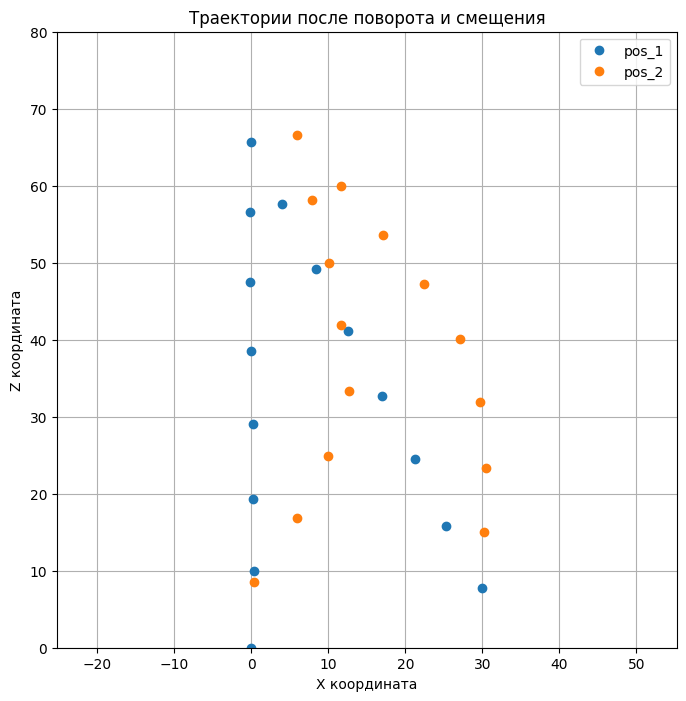

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, degrees, sin, cos

# Чтение данных из CSV
df = pd.read_csv('experimental_points_1.csv', header=None)

# Словарь для хранения траекторий
trajectories = {}

# Обработка каждой строки
for idx, row in df.iterrows():
    traj_name = row[0]
    coords = row[1:].values.astype(float)
    x_coords = coords[:15]  # Первые 15 значений — X
    z_coords = coords[15:]  # Следующие 15 — Z
    trajectories[traj_name] = {'x': x_coords, 'z': z_coords}

# Поворот на 90° по часовой стрелке: (X, Z) → (Z, -X)
# Отражаем по вертикали (Z → -Z)
rotated_trajectories = {}
for traj_name, coords in trajectories.items():
    rotated_x = -np.array(coords['z'])  # Поворот + отражение Z → -Z
    rotated_z = -np.array(coords['x'])  # Поворот X → -X
    rotated_trajectories[traj_name] = {'x': rotated_x, 'z': rotated_z}

# Определяем минимальные значения для сдвига
all_x = np.concatenate([traj['x'] for traj in rotated_trajectories.values()])
all_z = np.concatenate([traj['z'] for traj in rotated_trajectories.values()])
min_x, min_z = min(all_x), min(all_z)

# Сдвигаем все точки так, чтобы минимум был в (0, 0)
shifted_trajectories = {}
for traj_name, coords in rotated_trajectories.items():
    shift_x = coords['x'] - min_x
    shift_z = coords['z'] - min_z
    shifted_trajectories[traj_name] = {'x': shift_x, 'z': shift_z}

# Получаем данные для pos_1 после преобразований
pos1_data = shifted_trajectories['pos_1']
x_pos1, z_pos1 = pos1_data['x'], pos1_data['z']

# Вычисляем угол наклона линии между min_x и max_z точками
min_x_idx = np.argmin(x_pos1)
max_z_idx = np.argmax(z_pos1)
dx = x_pos1[max_z_idx] - x_pos1[min_x_idx]
dz = z_pos1[max_z_idx] - z_pos1[min_x_idx]
angle = atan2(dz, dx)
rotation_angle = np.pi/2 - angle  # Угол для вертикального положения

# Функция для поворота точек
def rotate_points(x, z, angle):
    rot_x = x * cos(angle) - z * sin(angle)
    rot_z = x * sin(angle) + z * cos(angle)
    return rot_x, rot_z

# Поворачиваем все траектории
rotated_final_trajectories = {}
for traj_name, coords in shifted_trajectories.items():
    rot_x, rot_z = rotate_points(coords['x'], coords['z'], rotation_angle)
    rotated_final_trajectories[traj_name] = {'x': rot_x, 'z': rot_z}

# Находим точку с минимальным Z в pos_1 после всех преобразований
pos1_rotated = rotated_final_trajectories['pos_1']
min_z_idx = np.argmin(pos1_rotated['z'])
reference_point = (pos1_rotated['x'][min_z_idx], pos1_rotated['z'][min_z_idx])

print(f"Точка с минимальным Z в pos_1: X={reference_point[0]:.2f}, Z={reference_point[1]:.2f}")

# Смещаем все точки pos_1 и pos_2 на координаты reference_point
final_trajectories = {}
for traj_name in ['pos_1', 'pos_2']:
    if traj_name in rotated_final_trajectories:
        final_x = rotated_final_trajectories[traj_name]['x'] - reference_point[0]
        final_z = rotated_final_trajectories[traj_name]['z'] - reference_point[1]
        final_trajectories[traj_name] = {'x': final_x, 'z': final_z}

# Создаем финальный график
plt.figure(figsize=(8, 8))

# Отображаем только pos_1 и pos_2
for traj_name in ['pos_1', 'pos_2']:
    if traj_name in final_trajectories:
        plt.plot(final_trajectories[traj_name]['x'], 
                final_trajectories[traj_name]['z'], 
                'o', label=traj_name)

# Настройка осей
plt.xlabel('X координата')
plt.ylabel('Z координата')
plt.title('Траектории после поворота и смещения')
plt.grid(True)
plt.axis('equal')
plt.xlim(-10, 40)  # X от –10 до 40 мм
plt.ylim(0, 80)    # Z от   0 до 80 мм
plt.legend()
plt.show()

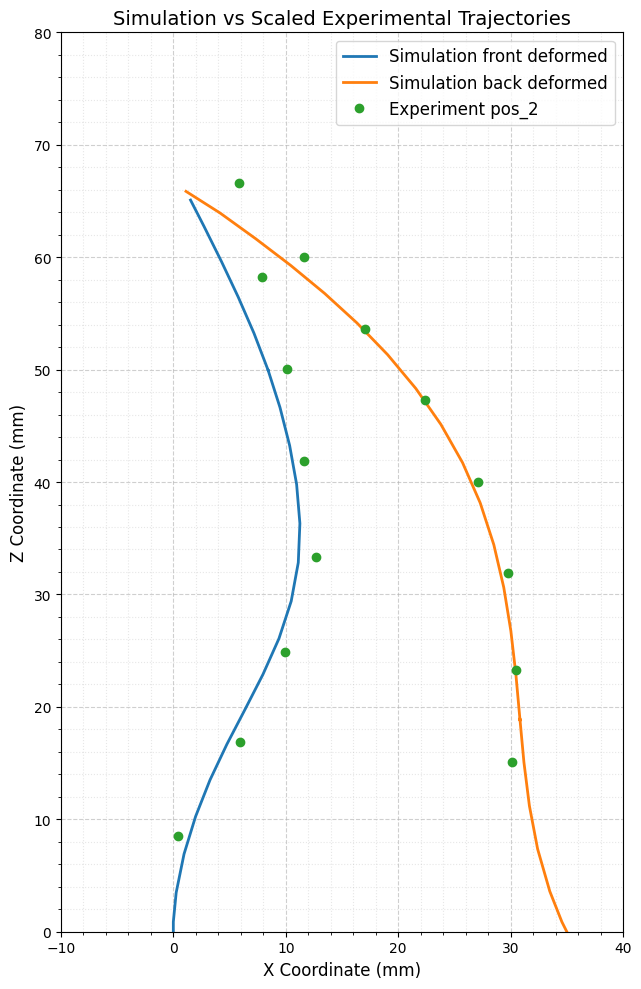

In [58]:
import mujoco
import mujoco_viewer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import atan2, sin, cos, pi, degrees

# =============================================
# Часть 1: Симуляция FinRay в MuJoCo
# =============================================

# Параметры симуляции
n_springs_front = 20
n_springs_back  = 20
n_springs_rib   = 12
L0 = 70e-3
X1 = 35e-3
beam_width = 35e-3
moving_cylinder_radius     = 20e-3
moving_cylinder_displacement = 12e-3
moving_cylinder_z          = 35e-3

th_front = 2e-3
th_back  = 4e-3
xf = 2000e-3
zf = 35e-3
phi_ribs = [0.5, 0, -0.5]
th_ribs  = [3e-3, 3e-3, 3e-3]

# Запуск симуляции (vis=False, без рендеринга)
pos_front_init, pos_front_deform, pos_back_init, pos_back_deform, \
con_Fx, con_Fz, con_Px, con_Pz, con_S, E_front, E_back, valid_rib_indices = \
    run_finray_simulation(
        rib_angles_deg=phi_ribs,
        thickness_ribs=th_ribs,
        n_springs_front=n_springs_front,
        n_springs_back=n_springs_back,
        n_springs_rib=n_springs_rib,
        thickness_front=th_front,
        thickness_back=th_back,
        beam_width=beam_width,
        L0=L0,
        X1=X1,
        xf=xf,
        zf=zf,
        moving_cylinder_x=moving_cylinder_radius + th_front/2,
        moving_cylinder_z=moving_cylinder_z,
        moving_cylinder_radius=moving_cylinder_radius,
        moving_cylinder_displacement=moving_cylinder_displacement,
        vis=True,
        stiffness_factor = 1.2
    )

# Преобразуем в мм
x_fi = pos_front_init[:,0]*1000;  z_fi = pos_front_init[:,1]*1000
x_fd = pos_front_deform[:,0]*1000; z_fd = pos_front_deform[:,1]*1000

x_bi = pos_back_init[:,0]*1000;   z_bi = pos_back_init[:,1]*1000
x_bd = pos_back_deform[:,0]*1000;  z_bd = pos_back_deform[:,1]*1000

# Сдвигаем корневую точку задней стенки в конец
x_bi = np.concatenate((x_bi[1:],  x_bi[:1]))
z_bi = np.concatenate((z_bi[1:],  z_bi[:1]))
x_bd = np.concatenate((x_bd[1:],  x_bd[:1]))
z_bd = np.concatenate((z_bd[1:],  z_bd[:1]))


# 2) Читаем и преобразуем экспериментальные данные
# =============================================
df = pd.read_csv('experimental_points_1.csv', header=None)
trajectories = {}
for _, row in df.iterrows():
    name = row[0]
    coords = row[1:].values.astype(float)
    trajectories[name] = {
        'x': coords[:15],
        'z': coords[15:]
    }

# Поворот (X,Z)->(Z,-X) с отражением Z→-Z
rotated = {}
for name, c in trajectories.items():
    rx = -c['z']
    rz = -c['x']
    rotated[name] = {'x': rx.copy(), 'z': rz.copy()}

# Сдвиг минимумы к (0,0)
all_x = np.hstack([r['x'] for r in rotated.values()])
all_z = np.hstack([r['z'] for r in rotated.values()])
min_x, min_z = all_x.min(), all_z.min()
shifted = {name: {'x': r['x']-min_x, 'z': r['z']-min_z}
           for name, r in rotated.items()}

# Поворот к вертикали по pos_1
x1 = shifted['pos_1']['x'];  z1 = shifted['pos_1']['z']
idx_minx = np.argmin(x1);  idx_maxz = np.argmax(z1)
dx, dz = x1[idx_maxz]-x1[idx_minx], z1[idx_maxz]-z1[idx_minx]
angle = atan2(dz, dx)
rot_ang = pi/2 - angle

def rotate_pts(x, z, ang):
    return x*cos(ang)-z*sin(ang), x*sin(ang)+z*cos(ang)

final = {}
for name, c in shifted.items():
    fx, fz = rotate_pts(c['x'], c['z'], rot_ang)
    final[name] = {'x': fx, 'z': fz}

# Сдвиг pos_1 и pos_2 относительно опорной точки
fz1 = final['pos_1']['z']
ref_i = np.argmin(fz1)
ref = (final['pos_1']['x'][ref_i], final['pos_1']['z'][ref_i])
for name in ['pos_1','pos_2']:
    fx = final[name]['x'] - ref[0]
    fz = final[name]['z'] - ref[1]
    final[name] = {'x':fx, 'z':fz}

# =============================================
# 3) Масштабирование Z-координат экспериментальных траекторий
# =============================================
# Текущая макс. высота pos_1
max_z1 = final['pos_1']['z'].max()
L0_mm = L0 * 1000  # целевая высота в мм (70 мм)
#scale = L0_mm / max_z1
scale = 1

for name in ['pos_1','pos_2']:
    final[name]['z'] *= scale

# =============================================
# 4) Рисуем всё вместе
# =============================================
plt.figure(figsize=(12,10))

# Симуляция
#plt.plot(x_fi, z_fi, '-', linewidth=2, label='Sim front init')
plt.plot(x_fd, z_fd, '-', linewidth=2, label='Simulation front deformed')
#plt.plot(x_bi, z_bi, '-', linewidth=2, label='Sim back init')
plt.plot(x_bd, z_bd, '-', linewidth=2, label='Simulation back deformed')

# Эксперимент
for name in ['pos_2']:
    plt.plot(final[name]['x'], final[name]['z'],
             'o', markersize=6, label=f'Experiment {name}')

# Сетка и оси
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.minorticks_on()
ax.grid(which='major', linestyle='--', alpha=0.6)
ax.grid(which='minor', linestyle=':',  alpha=0.3)

plt.xlabel('X Coordinate (mm)', fontsize=12)
plt.ylabel('Z Coordinate (mm)', fontsize=12)
plt.title('Simulation vs Scaled Experimental Trajectories', fontsize=14)
plt.xlim(-10, 40)
plt.ylim(0, 80)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()